In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore pandas deprecation warning
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm


In [4]:
# Testing utils
from utils import *

In [3]:
class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

## Get data

In [5]:
from utils import BASE_PATH, SPEC_DIR

from utils import metadata_df, process_all_specs, create_spec_npy_dirs
# Run this to convert the spectrograms to .npy
if False:
    create_spec_npy_dirs()
    process_all_specs()
    
metadata = metadata_df("train")
metadata_test = metadata_df("test")
display(metadata.head(2))


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0


In [6]:
metadata_test

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec_npy_path
0,853520,3911565283,6885,data/test_eegs/3911565283.parquet,data/test_spectrograms/853520.parquet,data/spectrograms_npy/test_spectrograms/853520...


## Visualize data

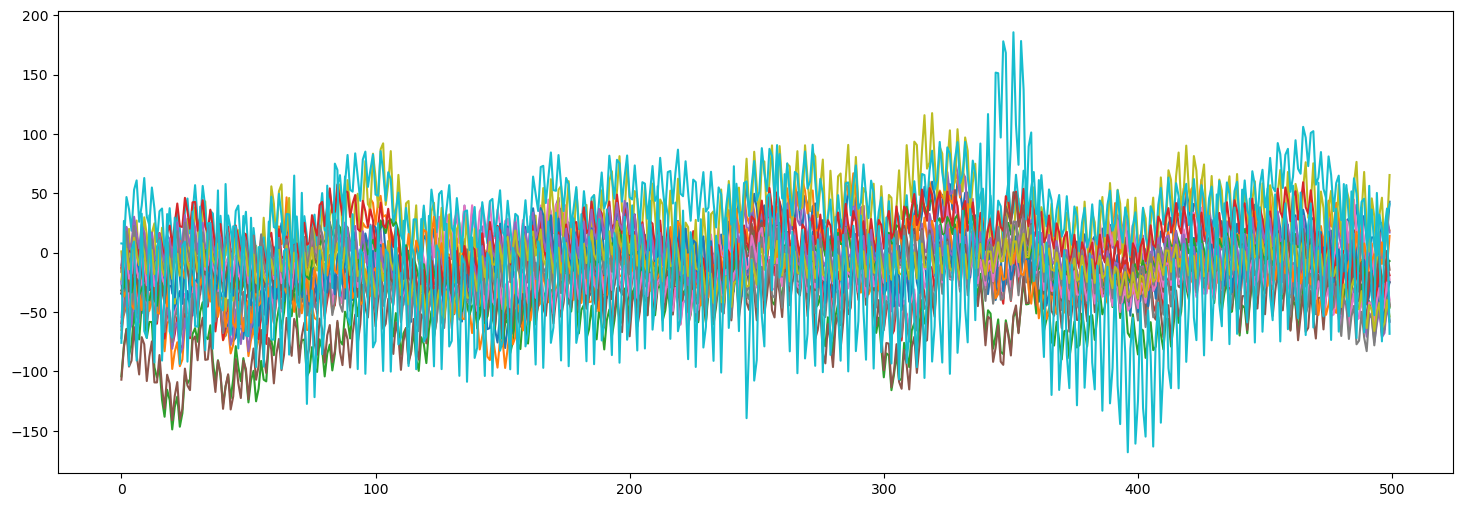

In [6]:
an_eeg = pd.read_parquet(metadata[metadata.expert_consensus == 'LPD'].iloc[0].eeg_path)
plt.figure(figsize=(18, 6))
plt.plot(an_eeg.iloc[:500]);

In [7]:
metadata.groupby("eeg_id").count()["eeg_sub_id"].value_counts()

eeg_sub_id
1      6324
2      1973
3      1430
4      1318
5       942
       ... 
101       1
85        1
236       1
210       1
226       1
Name: count, Length: 147, dtype: int64

In [8]:
idx = random.randint(0, len(metadata))
metadata.iloc[idx]

eeg_id                                                                     1176006128
eeg_sub_id                                                                         23
eeg_label_offset_seconds                                                        114.0
spectrogram_id                                                              708645713
spectrogram_sub_id                                                                 23
spectrogram_label_offset_seconds                                                114.0
label_id                                                                   4046775877
patient_id                                                                       9371
expert_consensus                                                                 LRDA
seizure_vote                                                                        0
lpd_vote                                                                            1
gpd_vote                                              

In [9]:
spec_parquet = pd.read_parquet(metadata.iloc[idx].spec_path)
spec_parquet.shape

(380, 401)

In [10]:
spec_parquet.columns[101:201]

Index(['RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56',
       'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73',
       'RL_2.93', 'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91',
       'RL_4.1', 'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08',
       'RL_5.27', 'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
       'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42',
       'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59',
       'RL_8.79', 'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77',
       'RL_9.96', 'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94',
       'RL_11.13', 'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
       'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28',
       'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45',
       'RL_14.65', 'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63',
       'RL_15.82', 'RL_16.02'

In [11]:
spec_parquet.tail()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
375,751,38.740002,67.360001,67.669998,55.509998,58.970001,31.850000,20.370001,16.620001,30.900000,...,0.35,0.44,0.23,0.48,0.51,0.45,0.45,0.41,0.26,0.23
376,753,30.930000,43.790001,52.310001,47.130001,40.500000,32.889999,13.000000,22.209999,21.400000,...,0.54,0.53,0.61,0.42,0.50,0.40,0.68,0.61,0.57,0.60
377,755,55.009998,73.830002,63.330002,82.889999,55.200001,36.439999,47.259998,25.780001,27.219999,...,0.69,0.62,0.67,0.59,0.41,0.43,0.51,0.63,0.52,0.53
378,757,76.260002,80.839996,76.989998,66.519997,43.430000,34.740002,39.160000,43.299999,40.619999,...,0.32,0.36,0.46,0.27,0.36,0.53,0.72,0.75,0.62,0.63
379,759,46.630001,70.599998,73.970001,68.849998,63.349998,47.310001,34.639999,56.150002,44.770000,...,0.39,0.49,0.35,0.34,0.36,1.16,1.15,1.30,1.60,0.52


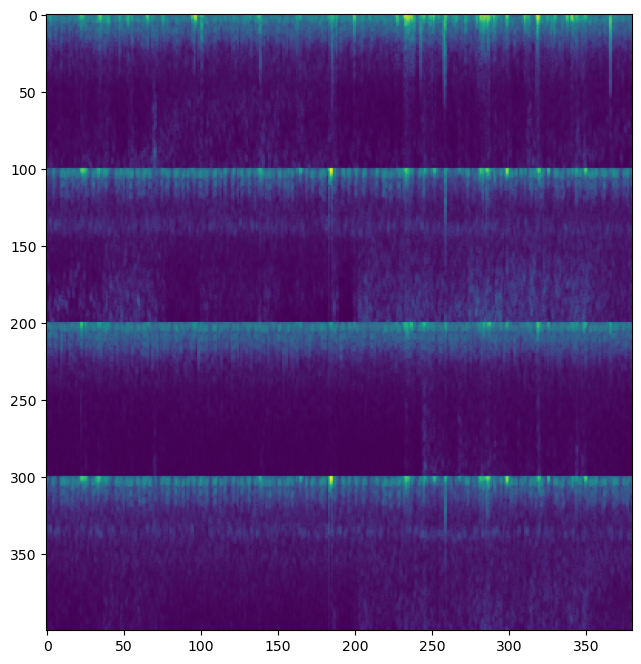

In [12]:
img = spec_parquet.iloc[:, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)

In [13]:
metadata[metadata.eeg_id == metadata.iloc[idx].eeg_id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
36002,1176006128,0,0.0,708645713,0,0.0,951985773,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36003,1176006128,1,6.0,708645713,1,6.0,3243480293,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36004,1176006128,2,8.0,708645713,2,8.0,1972850550,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36005,1176006128,3,10.0,708645713,3,10.0,1081882275,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36006,1176006128,4,12.0,708645713,4,12.0,1310761354,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36007,1176006128,5,14.0,708645713,5,14.0,1885140836,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36008,1176006128,6,18.0,708645713,6,18.0,453014332,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36009,1176006128,7,20.0,708645713,7,20.0,949885046,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36010,1176006128,8,26.0,708645713,8,26.0,934110048,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4
36011,1176006128,9,32.0,708645713,9,32.0,352963795,9371,GRDA,0,0,0,0,13,1,data/train_eegs/1176006128.parquet,data/train_spectrograms/708645713.parquet,data/spectrograms_npy/train_spectrograms/70864...,4


Note from the "time" column that the spectrogram data samples are spaced 2 seconds apart, starting at t=1. In other words, the parquet row is related to `time` by `time == 2*row + 1`. (I haven't checked this for every spectrogram!)

Each spectrogram item in the dataset is a 600-second window from the given file, starting at the even integer `spectrogram_label_offset_seconds`. In other words, the item consists of rows `[x/2:x/2+300]`, where `x=spectrogram_label_offset_seconds`.

For a better explanation that also includes the EEGs, see [this Kaggle post](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010).

Time offset: 114.0 s


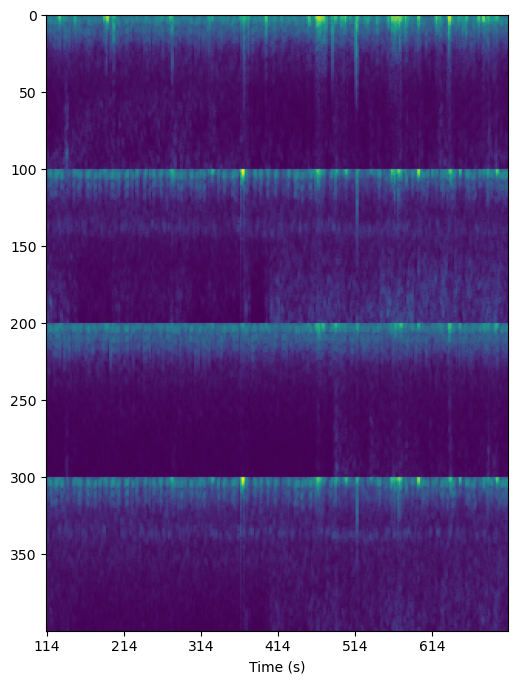

In [14]:
# Image of a single data item
x = metadata.iloc[idx].eeg_label_offset_seconds
print(f"Time offset: {x} s")
x = int(x)
img = spec_parquet.iloc[x//2:x//2+300, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.xticks(np.arange(0, 300, 50), np.arange(x, x+600, 100));
plt.xlabel("Time (s)");

## Define validation set

I'm going to use this to evaluate performance before submitting to Kaggle. Cross-validation should also be used.

Since the dataset includes groups of multiple items taken from the same underlying spectrogram, we have to take care that the validation set consists of entirely different spectrograms than the training set -- otherwise, the validation score might be biased.

In [16]:
valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)
metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")


11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.


## Define dataset and dataloader

In [17]:
from utils import SpectrogramDataset, SpectrogramTestDataset
train = SpectrogramDataset(metadata_train)
valid = SpectrogramDataset(metadata_valid)
test = SpectrogramTestDataset(metadata_test)
print(f"{len(train)} training items, {len(valid)} validation items, {len(test)} testing item.")

95346 training items, 11454 validation items, 1 testing item.


In [19]:
train[0]

(tensor([[ 4.2600,  2.6500,  4.1800,  ...,  1.8700,  3.2700,  4.1800],
         [10.9800,  3.9700,  4.5300,  ...,  3.5900,  5.6300,  5.8500],
         [ 9.0500, 12.1800,  8.7700,  ...,  8.6900,  9.4600,  7.2200],
         ...,
         [ 0.1600,  0.3100,  0.4800,  ...,  0.1000,  0.0800,  0.2500],
         [ 0.2200,  0.3600,  0.4400,  ...,  0.1000,  0.1300,  0.1700],
         [ 0.1900,  0.4000,  0.4800,  ...,  0.1000,  0.1400,  0.1500]]),
 tensor([3., 0., 0., 0., 0., 0.]))

In [20]:
test[0]

(tensor([[14.9100, 11.1300, 10.8800,  ...,  9.6100,  8.4300, 12.3300],
         [17.1100, 10.9500, 10.5700,  ..., 13.3200, 11.8400, 11.8400],
         [11.6600, 10.7700,  8.7900,  ...,  9.1900, 13.6400,  9.4200],
         ...,
         [ 0.0500,  0.0300,  0.0500,  ...,  0.3900,  0.4500,  0.4600],
         [ 0.0400,  0.0300,  0.0600,  ...,  0.5600,  0.4500,  0.5400],
         [ 0.0500,  0.0200,  0.0600,  ...,  0.2900,  0.3400,  0.2900]]),
 None)

In [21]:
train[0][0].shape

torch.Size([400, 300])

In a moment I'll plug this data into a vision model trained on color images. This model expects tensors of shape `[batch_size, 3, height, width]` (3 for RGB). The simplest way to encode grayscale images in this format is to send a grayscale pixel with value `x` to an RGB pixel with value `[x, x, x]`. It's easy to do this on batches, so I'll have the model do it -- this is slightly faster than doing it item-by-item on the dataset.

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, 32)
valid_loader = DataLoader(valid, 32)
train_iter = iter(train_loader)
train_batch = next(train_iter)
train_batch_2 = next(train_iter)
valid_batch = next(iter(valid_loader))
print(train_batch[0].shape, train_batch[1].shape)
print(train_batch_2[0].shape, train_batch_2[1].shape)
print(valid_batch[0].shape, valid_batch[1].shape)

torch.Size([32, 400, 300]) torch.Size([32, 6])
torch.Size([32, 400, 300]) torch.Size([32, 6])
torch.Size([32, 400, 300]) torch.Size([32, 6])


## Define metric and model

In [23]:
from scipy.stats import entropy
targ = torch.tensor([3, 0, 0, 0, 0, 0], dtype=torch.float)
dists = [
    torch.tensor([2/3, 1/3, 0, 0, 0, 0], dtype=torch.float),
    torch.tensor([1, 0, 0, 0, 0, 0], dtype=torch.float),
    torch.tensor([0.75, 0.25, 0, 0.25, 0, 0], dtype=torch.float),
    torch.tensor([0, 1, 0, 0, 0, 0], dtype=torch.float),
]
for dist in dists:
    print(dist.numpy())
    print(targ.numpy())
    print(f"Entropy {entropy(dist.numpy(), targ.numpy()):.3f}")
    print()

[0.6666667  0.33333334 0.         0.         0.         0.        ]
[3. 0. 0. 0. 0. 0.]
Entropy inf

[1. 0. 0. 0. 0. 0.]
[3. 0. 0. 0. 0. 0.]
Entropy 0.000

[0.75 0.25 0.   0.25 0.   0.  ]
[3. 0. 0. 0. 0. 0.]
Entropy inf

[0. 1. 0. 0. 0. 0.]
[3. 0. 0. 0. 0. 0.]
Entropy inf



In [24]:
entropy(train_batch[1].T, train_batch_2[1].T)

array([0.5108256, 0.5108256, 0.5108256,       inf,       inf,       inf,
             inf,       inf,       inf,       inf,       inf,       inf,
             inf,       inf,       inf,       inf,       inf,       inf,
             inf,       inf,       inf,       inf,       inf,       inf,
             inf,       inf,       inf,       inf,       inf,       inf,
             inf,       inf], dtype=float32)

In [25]:
# Also in torch
from torch.nn import KLDivLoss
loss_fn = KLDivLoss(reduction="batchmean")
# This expects LOGITS in its first argument (the model output).
# It expects targets to be ordinary observations
# Also, it doesn't like ints, so have to cast to float.

# TODO: Figure out how this is related to cross-entropy (above), and make sure that it's the right loss function.
for dist in dists:
    logit = torch.log(dist + 0.001)
    loss = loss_fn(logit, targ)
    print("Distribution:", dist.numpy())
    print("Approximate logit:", logit.numpy())
    print("Target:", targ.numpy())
    print(f"KL divergence {loss:.3f}.")
    print()


Distribution: [0.6666667  0.33333334 0.         0.         0.         0.        ]
Approximate logit: [-0.40396622 -1.0956168  -6.9077554  -6.9077554  -6.9077554  -6.9077554 ]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.751.

Distribution: [1. 0. 0. 0. 0. 0.]
Approximate logit: [ 9.9954696e-04 -6.9077554e+00 -6.9077554e+00 -6.9077554e+00
 -6.9077554e+00 -6.9077554e+00]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.549.

Distribution: [0.75 0.25 0.   0.25 0.   0.  ]
Approximate logit: [-0.28634965 -1.3823024  -6.9077554  -1.3823024  -6.9077554  -6.9077554 ]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.692.

Distribution: [0. 1. 0. 0. 0. 0.]
Approximate logit: [-6.9077554e+00  9.9954696e-04 -6.9077554e+00 -6.9077554e+00
 -6.9077554e+00 -6.9077554e+00]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 4.003.



## Build and train model

In [34]:
from utils import Spectrogram_EfficientNet

train = SpectrogramDataset(metadata_train)
valid = SpectrogramDataset(metadata_valid)
test = SpectrogramTestDataset(metadata_test)
train_loader = DataLoader(train, 32, shuffle=True)
valid_loader = DataLoader(valid, 32)
model = Spectrogram_EfficientNet()

summary(model, col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        depth=4,
        row_settings=["depth", "var_names"],
        input_data=train_batch[0])

Layer (type (var_name):depth-idx)                                      Input Shape          Output Shape         Trainable
Spectrogram_EfficientNet (Spectrogram_EfficientNet)                    [32, 400, 300]       [32, 6]              Partial
├─EfficientNet (efficientnet): 1-1                                     [32, 3, 400, 300]    [32, 6]              Partial
│    └─Sequential (features): 2-1                                      [32, 3, 400, 300]    [32, 1280, 13, 10]   False
│    │    └─Conv2dNormActivation (0): 3-1                              [32, 3, 400, 300]    [32, 32, 200, 150]   False
│    │    │    └─Conv2d (0): 4-1                                       [32, 3, 400, 300]    [32, 32, 200, 150]   False
│    │    │    └─BatchNorm2d (1): 4-2                                  [32, 32, 200, 150]   [32, 32, 200, 150]   False
│    │    │    └─SiLU (2): 4-3                                         [32, 32, 200, 150]   [32, 32, 200, 150]   --
│    │    └─Sequential (1): 3-2            

In [35]:
model.to(DEVICE);

In [38]:
from utils import Trainer
trainer = Trainer(model, train_loader, valid_loader,
                  criterion=KLDivLoss(reduction="batchmean"), lr=0.1)

trainer.train_eval_loop(len(train_loader), 1000, 500)

Training: 4776it [05:18, 15.02it/s]                                         


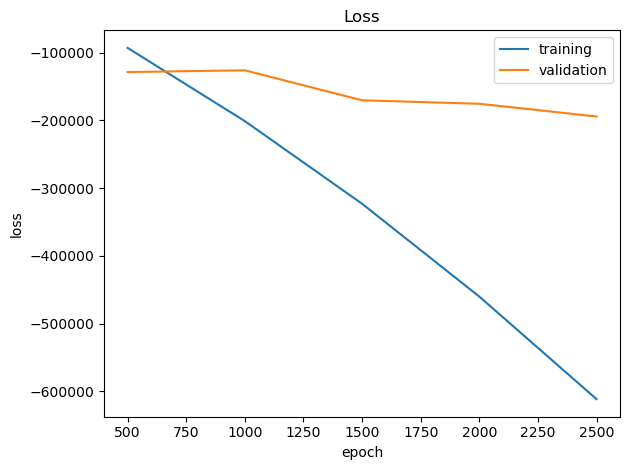

In [39]:
trainer.plot_metrics()